In [ ]:
# required libraries

import os
import re
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from google.colab import files

from pathlib import Path
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers

## Loading Data

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d limonhalder/fetal-head-circumference-data

Saving kaggle.json to kaggle.json
 99% 167M/168M [00:10<00:00, 18.6MB/s]
100% 168M/168M [00:10<00:00, 16.7MB/s]


In [ ]:
!unzip fetal-head-circumference-data

## Preparing data

In [ ]:
image_dir = Path('/content/Fetal Head Circumference/train_set/Images')
image_path = list(image_dir.glob(r'**/*.png'))
image_path.sort()
image_str_path = pd.Series(image_path, name='ImagePath').astype(str)
image_name = pd.Series([i.split("/")[-1] for i in image_str_path], name='ImageName')
data = pd.concat([image_str_path,image_name], axis=1)

mask_dir = Path('/content/Fetal Head Circumference/train_set/Annotation')
mask_path = list(mask_dir.glob(r'**/*.png'))
mask_path.sort()
mask_str_path = pd.Series(mask_path, name='MaskPath').astype(str)
mask_name = pd.Series([re.sub('_Annotation','',i.split("/")[-1]) for i in mask_str_path], name='ImageName')
mask_data = pd.concat([mask_str_path,mask_name], axis=1)

data = data.merge(mask_data, on='ImageName')
data = data[['ImageName','ImagePath','MaskPath']]
data.head()

,ImageName,ImagePath,MaskPath
0,000_HC.png,/content/Fetal Head Circumference/train_set/Im...,/content/Fetal Head Circumference/train_set/An...
1,001_HC.png,/content/Fetal Head Circumference/train_set/Im...,/content/Fetal Head Circumference/train_set/An...
2,002_HC.png,/content/Fetal Head Circumference/train_set/Im...,/content/Fetal Head Circumference/train_set/An...
3,003_HC.png,/content/Fetal Head Circumference/train_set/Im...,/content/Fetal Head Circumference/train_set/An...
4,004_HC.png,/content/Fetal Head Circumference/train_set/Im...,/content/Fetal Head Circumference/train_set/An...


In [ ]:
def load_images(input):
  output = Image.open(input)
  output = output.resize((256,256))
  output = np.expand_dims(output, axis=0)
  return output

In [ ]:
# Make dataset
X = np.array([load_images(i) for i in data['ImagePath']]).reshape(999,256,256)
y = np.array([load_images(i) for i in data['MaskPath']]).reshape(999,256,256)

# scale dataset
X = (X/127.5)
y = (y/127.5)

In [ ]:
def display(display_list):
  plt.figure(figsize=(12, 12))
  title = ['Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i], cmap='gray')
    plt.axis('off')
  plt.show()

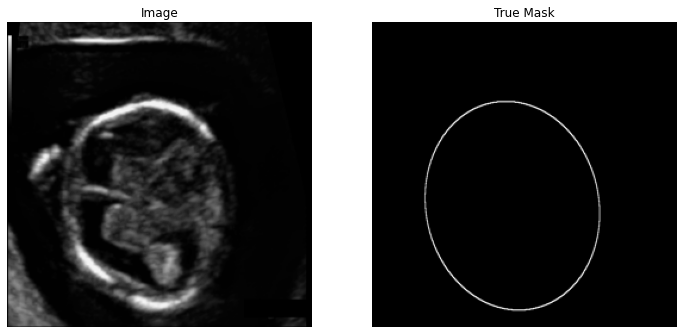

In [ ]:
# let's see one of the example
display([X[123], y[123]])

## Data Augmentation

In [ ]:
def augmentation(imgs, masks):
  X_aug = []
  y_aug = []

  for img, mask in zip(imgs, masks):
      # main data
      X_aug.append(img)
      y_aug.append(mask)

      img_lr = np.fliplr(img)
      mask_lr = np.fliplr(mask)

      # augmented data
      X_aug.append(img_lr)
      y_aug.append(mask_lr)

  return X_aug, y_aug

In [ ]:
# Augment images
X_aug, y_aug = augmentation(X, y)
X_aug = np.array(X_aug).reshape(len(X_aug),256,256)
y_aug = np.array(y_aug).reshape(len(y_aug),256,256)

# split dataset
X_train, X_val, y_train, y_val = train_test_split(X_aug, y_aug, test_size=0.2, random_state=42)

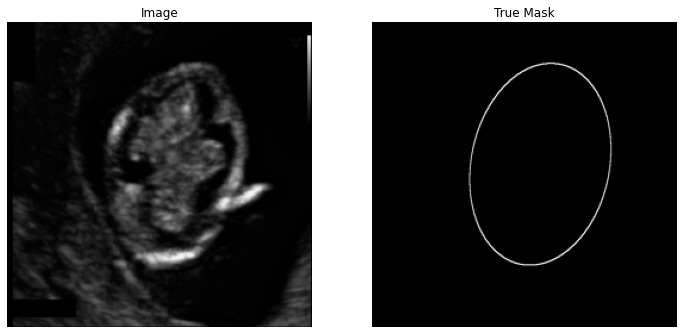

In [ ]:
# let's see an augmented example
display([X_aug[123], y_aug[123]])

## U-net implimentation

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True, activation='relu'):

    # first conv layer
    x = layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    # second conv layer
    x = layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    return x

In [ ]:
def get_unet(input_img, n_filters=16, dropout = 0.1, batchnorm = True, activation='relu'):

    # encoder path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm, activation = activation)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm, activation = activation)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm, activation = activation)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm, activation = activation)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    p4 = layers.Dropout(dropout)(p4)

    # latent space
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm, activation = activation)

    # decoder path
    u6 = layers.Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = layers.Concatenate()([u6, c4])
    u6 = layers.Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm, activation = activation)

    u7 = layers.Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = layers.Concatenate()([u7, c3])
    u7 = layers.Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm, activation = activation)

    u8 = layers.Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = layers.Concatenate()([u8, c2])
    u8 = layers.Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm, activation = activation)

    u9 = layers.Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = layers.Concatenate()([u9, c1])
    u9 = layers.Dropout(dropout)(u9)
    c9 = conv2d_block(u9,  n_filters * 1, kernel_size = 3, batchnorm = batchnorm, activation = activation)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = tf.keras.Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = layers.Input((256,256,1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.3, batchnorm=True, activation='relu')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

In [ ]:
EPOCHS = 20
model_history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val))

Epoch 1/20
50/50 [==============================] - 30s 349ms/step - loss: 0.4069 - accuracy: 0.9027 - val_loss: 3.6105 - val_accuracy: 0.3729
Epoch 2/20
50/50 [==============================] - 13s 262ms/step - loss: 0.1974 - accuracy: 0.9802 - val_loss: 0.1677 - val_accuracy: 0.9744
Epoch 3/20
50/50 [==============================] - 13s 265ms/step - loss: 0.1441 - accuracy: 0.9816 - val_loss: 0.1188 - val_accuracy: 0.9781
Epoch 4/20
50/50 [==============================] - 13s 267ms/step - loss: 0.1161 - accuracy: 0.9818 - val_loss: 0.0971 - val_accuracy: 0.9807
Epoch 5/20
50/50 [==============================] - 13s 264ms/step - loss: 0.0972 - accuracy: 0.9819 - val_loss: 0.0839 - val_accuracy: 0.9818
Epoch 6/20
50/50 [==============================] - 13s 261ms/step - loss: 0.0838 - accuracy: 0.9820 - val_loss: 0.0734 - val_accuracy: 0.9821
Epoch 7/20
50/50 [==============================] - 13s 261ms/step - loss: 0.0741 - accuracy: 0.9820 - val_loss: 0.0668 - val_accuracy: 0.9821

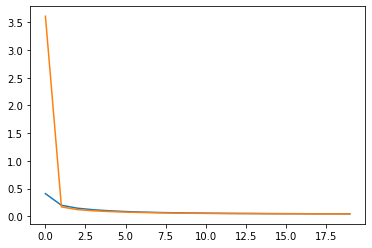

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss']);

## Prediction phase

1/1 [==============================] - 0s 15ms/step


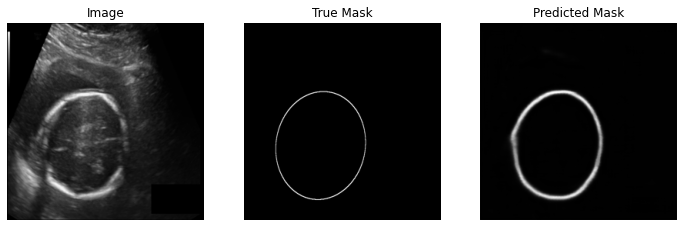

In [ ]:
# let's see a random predicted mask
ts = np.random.randint(len(X_val))
y_pred = model.predict(X_val[ts:ts+1])
y_pred = y_pred.reshape((256,256))
display([X_val[ts], y_val[ts], y_pred])

## Predict masks of the whole dataset

In [ ]:
to_be_saves = model.predict(X)
to_be_saves = to_be_saves.reshape((999,256,256))

32/32 [==============================] - 3s 83ms/step


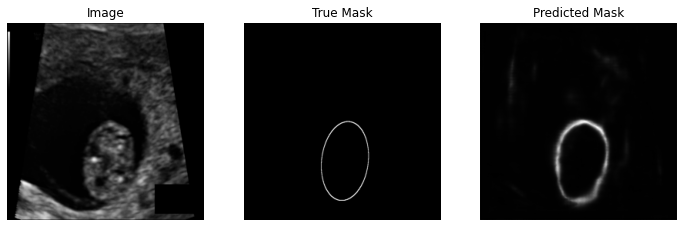

In [ ]:
# check order of images for their names
display([X[0], y[0], to_be_saves[0]])

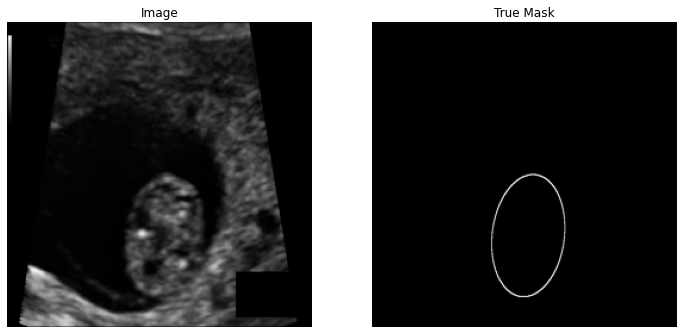

In [ ]:
display([Image.open(data.ImagePath[0]).resize((256,256)),
         Image.open(data.MaskPath[0]).resize((256,256))])

## Save all masks

In [ ]:
# save masks
!mkdir 'PredictedMasks'
save_path = '/content/PredictedMasks'

for i in range(len(to_be_saves)):
  masks_to_save = Image.fromarray(np.uint8(to_be_saves[i]/(1/256)))
  masks_to_save.save(f"{save_path}/{data.ImageName[i]}")

In [ ]:
# download
!zip -r /content/PredictedMasks.zip //content/PredictedMasks
files.download('/content/PredictedMasks.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>